In [1]:
# import pandas as pd
# df_tickers = pd.read_csv("biotech_tickers.csv")
# unique_tickers_list = df_tickers.Ticker.unique().tolist()
# unique_tickers_list

2024-10-14 09:42:11,701 - ERROR - APGE: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:21,161 - ERROR - CGON: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
2024-10-14 09:42:21,679 - ERROR - GPCR: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:23,046 - ERROR - NMRA: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:33,517 - ERROR - FTRE: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:45,858 - ERROR - BCAX: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
2024-10-14 09:42:46,164 - WARNING - No financial data for BCAX.
2024-10-14 09:42:53,323 - ERROR - AVBP: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', '

                Strategy  Sharpe Ratio  \
0         Short Strategy     -0.800888   
1  Buy and Hold Strategy      0.228921   

                                        Max Drawdown  
0  [0.9793867888564044, 0.9793867888564044, 0.979...  
1  [2.4308644123813066, 2.4308644123813066, 2.369...  


<Figure size 1000x600 with 0 Axes>

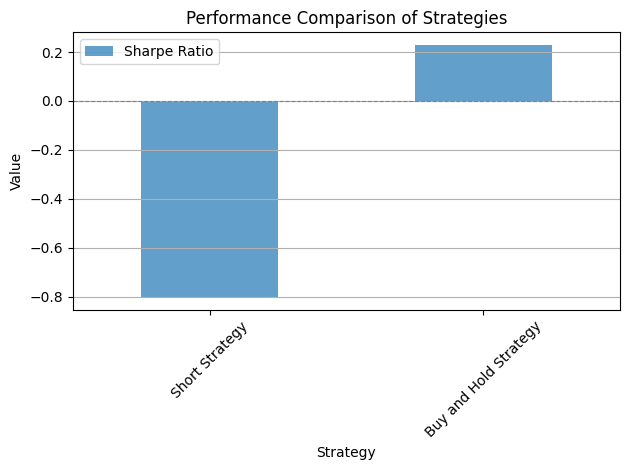

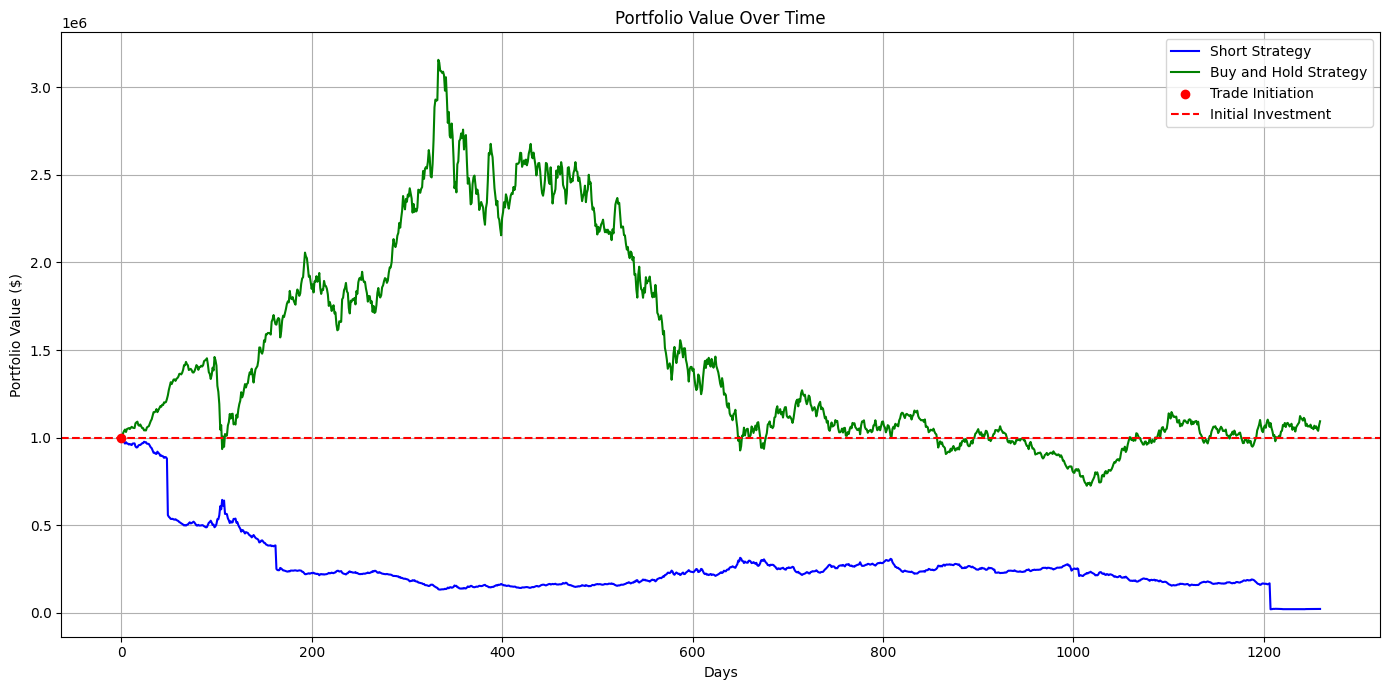

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

df_tickers = pd.read_csv("biotech_tickers.csv")
unique_tickers_list = df_tickers.Ticker.unique().tolist()
unique_tickers_list

# Fetch stock data function
def fetch_stock_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="5y")

        # Fetch quarterly financial metrics
        quarterly_info = stock.quarterly_financials.T
        balance_sheet_info = stock.quarterly_balance_sheet.T
        
        if quarterly_info.empty or balance_sheet_info.empty:
            logging.warning(f"No financial data for {ticker}.")
            return None, None
        
        quarters_data = []
        for date in quarterly_info.index:
            revenue = quarterly_info.get('Total Revenue', pd.Series()).get(date, np.nan)
            net_income = quarterly_info.get('Net Income', pd.Series()).get(date, np.nan)
            total_assets = balance_sheet_info.get('Total Assets', pd.Series()).get(date, np.nan)
            total_liabilities = balance_sheet_info.get('Total Liabilities Net Minority Interest', pd.Series()).get(date, np.nan)
            
            shareholder_equity = total_assets - total_liabilities if total_assets and total_liabilities else np.nan
            
            quarters_data.append({
                'ticker': ticker,
                'fetched_date': datetime.now().date(),
                'latest_quarter': date,
                'revenue': revenue,
                'net_income': net_income,
                'total_assets': total_assets,
                'total_liabilities': total_liabilities,
                'shareholder_equity': shareholder_equity,
            })

        return hist['Close'].dropna(), quarters_data
    except Exception as e:
        logging.error(f"Error fetching data for {ticker}: {e}")
        return None, None

# List of biotech tickers
biotech_tickers = unique_tickers_list #['AMGN', 'GILD', 'VRTX', 'REGN', 'BIIB']

# Fetch historical data and financial metrics
close_data = []
financial_data = []
for ticker in biotech_tickers:
    adjusted_close, quarters_data = fetch_stock_data(ticker)
    if adjusted_close is not None:
        close_data.append(adjusted_close.to_frame(name=ticker))
        financial_data.extend(quarters_data)

price_close_df = pd.concat(close_data, axis=1)
financial_df = pd.DataFrame(financial_data)

# Determine stocks to short based on debt-to-equity ratio
def determine_shorts(financial_df):
    financial_df['debt_to_equity'] = financial_df['total_liabilities'] / financial_df['shareholder_equity']
    top_20_percent_debt_to_equity = financial_df['debt_to_equity'].quantile(0.8)
    shorts_candidates = financial_df[financial_df['debt_to_equity'] > top_20_percent_debt_to_equity]
    return shorts_candidates['ticker'].unique()

# Shorting strategy backtest
short_tickers = determine_shorts(financial_df)
initial_investment = 1_000_000

def backtest_short_strategy(price_close_df, short_tickers):
    portfolio_value = initial_investment
    daily_returns = price_close_df.pct_change().fillna(0)
    
    shorted_returns = daily_returns[short_tickers]
    num_shorts = len(short_tickers)
    allocation_per_stock = portfolio_value / num_shorts if num_shorts > 0 else 0

    portfolio_values_short = [portfolio_value]

    for date in shorted_returns.index:
        if date in shorted_returns.index:
            daily_portfolio_return = (shorted_returns.loc[date] * -1).mean()  # Shorting profits when prices fall
            portfolio_value *= (1 + daily_portfolio_return)
            portfolio_values_short.append(portfolio_value)

    return portfolio_values_short

def backtest_buy_and_hold(price_close_df):
    initial_prices = price_close_df.iloc[0]
    buy_hold_values = [initial_investment]
    
    for date in price_close_df.index:
        current_prices = price_close_df.loc[date]
        returns_per_stock = current_prices / initial_prices - 1
        average_return_per_stock = returns_per_stock.mean()
        
        current_portfolio_value_buy_hold = initial_investment * (1 + average_return_per_stock)
        buy_hold_values.append(current_portfolio_value_buy_hold)

    return buy_hold_values

def calculate_performance_metrics(portfolio_values):
    daily_returns = np.array(portfolio_values[1:]) / np.array(portfolio_values[:-1]) - 1
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values) / np.maximum.accumulate(portfolio_values)
    return sharpe_ratio, max_drawdown

if len(short_tickers) > 0:
    portfolio_values_short = backtest_short_strategy(price_close_df, short_tickers)
    buy_hold_values_over_time = backtest_buy_and_hold(price_close_df)
    
    # Calculate performance metrics
    short_sharpe, short_max_drawdown = calculate_performance_metrics(portfolio_values_short)
    buy_hold_sharpe, buy_hold_max_drawdown = calculate_performance_metrics(buy_hold_values_over_time)

    # Create a summary DataFrame for statistics
    performance_df = pd.DataFrame({
        'Strategy': ['Short Strategy', 'Buy and Hold Strategy'],
        'Sharpe Ratio': [short_sharpe, buy_hold_sharpe],
        'Max Drawdown': [short_max_drawdown, buy_hold_max_drawdown]
    })

    # Display performance statistics as a table
    print(performance_df)

    # Visualization: Bar plot for Sharpe Ratio and Max Drawdown
    plt.figure(figsize=(10, 6))
    performance_df.set_index('Strategy').plot(kind='bar', alpha=0.7)
    plt.title('Performance Comparison of Strategies')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plotting portfolio value over time for both strategies
    plt.figure(figsize=(14, 7))
    
    plt.plot(portfolio_values_short, label='Short Strategy', color='blue')
    plt.plot(buy_hold_values_over_time, label='Buy and Hold Strategy', color='green')
    
    plt.scatter([0], [initial_investment], color='red', label='Trade Initiation', zorder=5)

    plt.title('Portfolio Value Over Time')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value ($)')
    plt.axhline(y=initial_investment, color='red', linestyle='--', label='Initial Investment')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    logging.warning("No tickers were selected for shorting based on the criteria.")


Strategies
Short Selling Strategy:

Objective: Profit from a decline in stock prices.
Process:
Debt-to-Equity Ratio Calculation: The code calculates the debt-to-equity ratio for each stock using total liabilities and shareholder equity.
Selection Criteria: Stocks in the top 20% of the highest debt-to-equity ratios are identified as candidates for shorting, indicating higher financial risk.
Execution: Simulates selling these stocks short, meaning you borrow shares and sell them at the current price with the hope of buying them back later at a lower price.
Performance Measurement: Calculates the portfolio's value over time based on daily returns from shorted stocks, aiming to capture profits from their price declines.
Buy and Hold Strategy:

Objective: Profit from long-term appreciation of stock prices.
Process:
Initial Investment: Invests a set amount in selected stocks at the beginning.
Value Calculation: Tracks the portfolio's value over time based on the appreciation of the stocks held, calculating returns from the initial investment without selling.
Performance Measurement: Evaluates how the portfolio grows based on the average returns of all stocks in the portfolio.